## Section 0 - Imports

In [1]:
# %matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
from scipy import ndimage
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
from skimage.color import lab2rgb , rgb2lab
from skimage import feature
from skimage import filters

import scipy.fftpack
import scipy.signal as signal

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cluster import KMeans

import copy
import time

from openTSNE import TSNE as opTSNE


'''
import matplotlib
import scipy
import sklearn
import skimage
import mpl_toolkits
import openTSNE
'''

'\nimport matplotlib\nimport scipy\nimport sklearn\nimport skimage\nimport mpl_toolkits\nimport openTSNE\n'

In [2]:
'''


print("numpy = " + np.__version__)
print("matplotlib = " + matplotlib.__version__)
print("h5py = " + h5py.__version__)
print("scipy = " + scipy.__version__)
print("pandas = " + pd.__version__)
print("sklearn = " + sklearn.__version__)
print("skimage = " + skimage.__version__)
print("seaborn = " + sns.__version__)
print("openTSNE = " + openTSNE.__version__)

'''

'\n\n\nprint("numpy = " + np.__version__)\nprint("matplotlib = " + matplotlib.__version__)\nprint("h5py = " + h5py.__version__)\nprint("scipy = " + scipy.__version__)\nprint("pandas = " + pd.__version__)\nprint("sklearn = " + sklearn.__version__)\nprint("skimage = " + skimage.__version__)\nprint("seaborn = " + sns.__version__)\nprint("openTSNE = " + openTSNE.__version__)\n\n'

## Section 1 - Data Preparation

In [3]:
h5 = h5py.File('GastricData.mat', 'r')

#print(list(h5.keys()))

# Get all data variables and store them

# Clinical_data not read correctly, read by CSV
#Clinical_data= h5.get('Clinical_data')[:]

HE_image= h5.get('HE_image')[:]
HE_image = HE_image.swapaxes(0,2)


MSI_data_cube= h5.get('MSI_data_cube')[:]
MSI_data_cube = MSI_data_cube.swapaxes(0,2)

goodlist= h5.get('goodlist')[:]
goodlist = goodlist.swapaxes(0,1)

peak_list= h5.get('peak_list')[:]
peak_list = peak_list.swapaxes(0,1)

pixel_to_sample_ID= h5.get('pixel_to_sample_ID')[:]
pixel_to_sample_ID = pixel_to_sample_ID.swapaxes(0,1)  

h5.close()

# Clinical_data = pd.read_excel('ClinicalData.xlsx')

height , width = (pixel_to_sample_ID.shape) # ( 443 , 1653 )

flattened_MSI_data_cube = MSI_data_cube.flatten().reshape(MSI_data_cube.shape[0] * MSI_data_cube.shape[1] , MSI_data_cube.shape[2])

# The scaler object (model)
scaler = StandardScaler()
# fit and transform the data
scaled_data = scaler.fit_transform(flattened_MSI_data_cube) 

flattened_pixel_to_sample_ID = pixel_to_sample_ID.flatten() 

indices = np.where(flattened_pixel_to_sample_ID == -1)
indices_sampleID = np.where(flattened_pixel_to_sample_ID == -1 )

In [4]:
scaled_data.shape


(732279, 82)

In [5]:
Sample_1 = 1
Sample_2 = 18
Sample_3 = 59

In [6]:
sample_only_scaled_data = np.delete(scaled_data, indices[0] , axis=0)
sample_ID_pixels = np.delete(flattened_pixel_to_sample_ID , indices_sampleID[0] , axis=0)
original_sample_ID_pixels = copy.deepcopy(sample_ID_pixels)

# Pick 3 samples
mask = (sample_ID_pixels == Sample_1 ) 
samples_selected = sample_ID_pixels
samples_selected[mask] = 100

mask = (sample_ID_pixels == Sample_2 ) 
samples_selected[mask] = 200

mask = (sample_ID_pixels == Sample_3 ) 
samples_selected[mask] = 300

# Make other samples the same low intensity color
mask = (sample_ID_pixels <= 63) 
samples_selected[mask] = 1

## Section 2 - PCA

In [7]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(sample_only_scaled_data)

pca_df = pd.DataFrame(data=pca_result[:],columns=["PC1","PC2","PC3","PC4","PC5"])
print('Explained variation per PC: {}'.format(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_

Explained variation per PC: [0.17506106 0.09651383 0.06742341 0.0467137  0.04414015]


Text(0, 0.5, 'Variance Percentage')

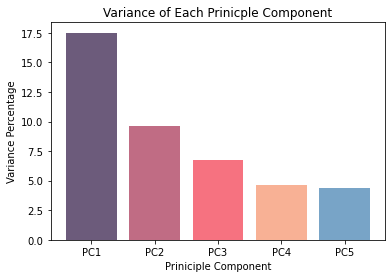

In [8]:
PCA=["PC1","PC2","PC3","PC4","PC5"]

COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195", "#78a4c7"]

plt.bar(PCA, variance*100, color=COLORS)

plt.title('Variance of Each Prinicple Component')
plt.xlabel('Priniciple Component')
plt.ylabel('Variance Percentage')

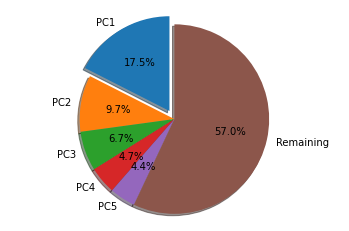

Variance Represented by PCA = 42.99 %


In [9]:
# Pie chart
labels = 'PC1', 'PC2', 'PC3', 'PC4' , 'PC5' , 'Remaining'
sizes = [ variance[0], variance[1], variance[2], variance[3] , variance[4] , 1 - ( variance[0] + variance[1] + variance[2] + variance[3] + variance[4] )  ]
explode = (0.1, 0, 0, 0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
print('Variance Represented by PCA = ' + str(round((variance[0] + variance[1] + variance[2] + variance[3] + variance[4])*100 , 2) ) +' %')

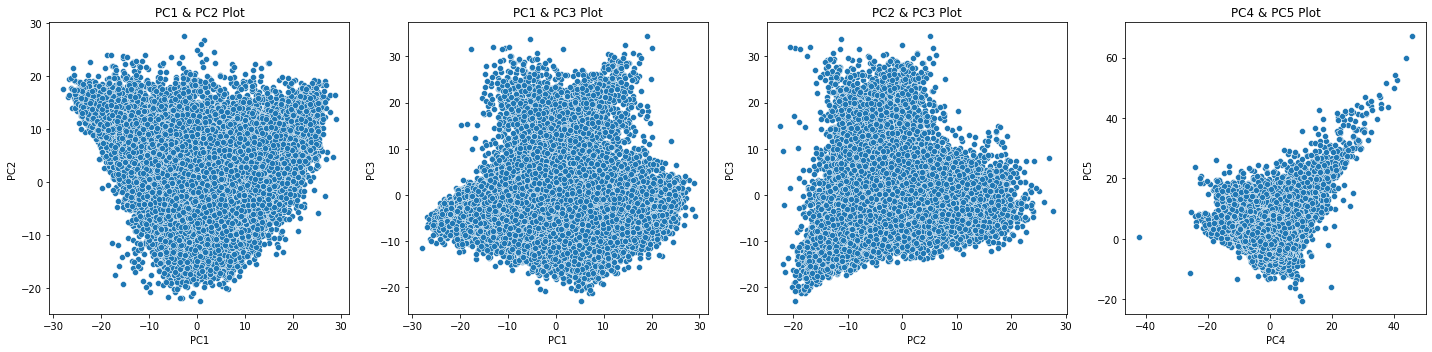

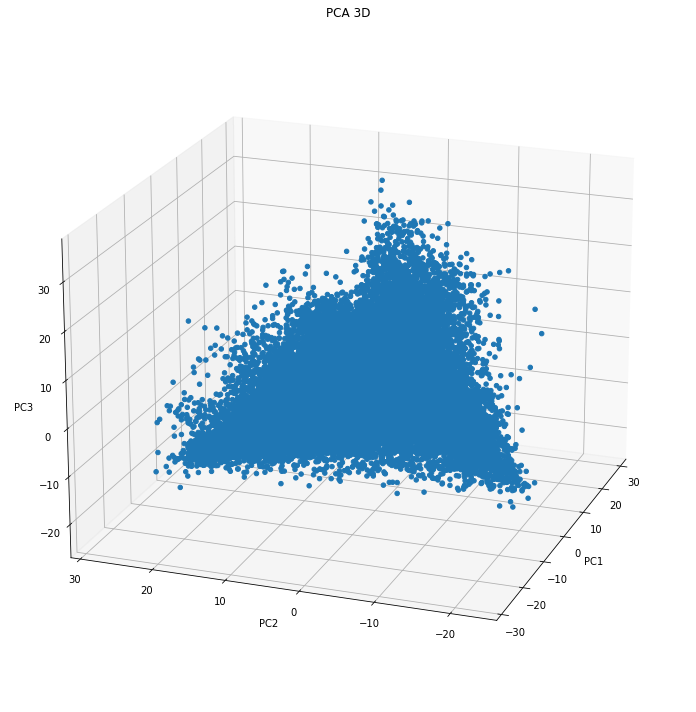

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(
    ax=axes[0],
    x="PC1", y="PC2",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[0].set_title("PC1 & PC2 Plot")
sns.scatterplot(
    ax=axes[1],
    x="PC1", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[1].set_title("PC1 & PC3 Plot")
sns.scatterplot(
    ax=axes[2],
    x="PC2", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[2].set_title("PC2 & PC3 Plot")

sns.scatterplot(
    ax=axes[3],
    x="PC4", y="PC5",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[3].set_title("PC4 & PC5 Plot")

plt.tight_layout()
plt.show()

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=pca_df['PC1'], 
    ys=pca_df['PC2'], 
    zs=pca_df['PC3'], 
    alpha = 1
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("PCA 3D")

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


## Section 3 - tSNE

In [11]:
'''
time_start = time.time()
tsne = opTSNE(
    n_components = 3,
    perplexity = 40,
    learning_rate = 'auto',
    early_exaggeration_iter = 50,
    early_exaggeration = 4,
    n_iter = 1000,
    initialization = 'random',
    initial_momentum = 0.5,
    final_momentum = 0.8,
    metric="euclidean",
    n_jobs=8,
    random_state=0,
    negative_gradient_method = 'barnes-hut',
    verbose=True,
)

%time tsne_results_op = tsne.fit(sample_only_scaled_data)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

np.save('op_tSNE_Results_' + 'Time_{}_seconds'.format(time.time()-time_start) , tsne_results)
'''

'\ntime_start = time.time()\ntsne = opTSNE(\n    n_components = 3,\n    perplexity = 40,\n    learning_rate = \'auto\',\n    early_exaggeration_iter = 50,\n    early_exaggeration = 4,\n    n_iter = 1000,\n    initialization = \'random\',\n    initial_momentum = 0.5,\n    final_momentum = 0.8,\n    metric="euclidean",\n    n_jobs=8,\n    random_state=0,\n    negative_gradient_method = \'barnes-hut\',\n    verbose=True,\n)\n\n%time tsne_results_op = tsne.fit(sample_only_scaled_data)\n\nprint(\'t-SNE done! Time elapsed: {} seconds\'.format(time.time()-time_start))\n\nnp.save(\'op_tSNE_Results_\' + \'Time_{}_seconds\'.format(time.time()-time_start) , tsne_results)\n'

In [12]:
# Util function for convert-to (0 - 1) range
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)
def rescale_AB(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return ( (arr - arr_min) / (arr_max - arr_min)  ) * 255 - 128

In [13]:
# Load the t-SNE results
op_tsne_results = np.load('op_tSNE_Results_Time_456.8306334018707_seconds.npy')

In [14]:
tsne_df = pd.DataFrame(data=op_tsne_results[:],columns=["tSNE_dim1","tSNE_dim2","tSNE_dim3"])
tsne_df['pixel_ID'] = samples_selected
tsne_df['L_Component'] = op_tsne_results[:,0]
tsne_df['A_Component'] = op_tsne_results[:,1]
tsne_df['B_Component'] = op_tsne_results[:,2]

In [15]:
# Converting tSNE dimensions to be represented 

LAB_mapping = [ tsne_df['L_Component'] , tsne_df['A_Component'] , tsne_df['B_Component'] ]
LAB_colors = np.asarray(LAB_mapping)
LAB_colors = LAB_colors.swapaxes(0,1)

L = rescale(LAB_colors[:,0]) * 100
A = rescale_AB(LAB_colors[:,1])
B = rescale_AB(LAB_colors[:,2])
LAB_colors = np.asarray( [ L , A , B ] )
LAB_colors = LAB_colors.swapaxes(0,1)
RGB_colors = lab2rgb(LAB_colors)


C:\Users\omars\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1504 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


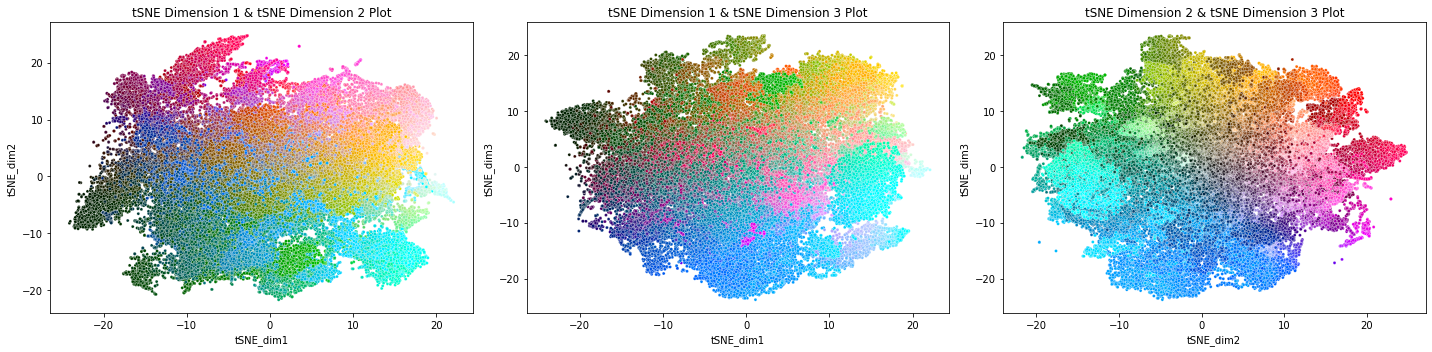

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})
marker_size = 9

sns.scatterplot(
    ax = axes[0],
    x = "tSNE_dim1", y="tSNE_dim2",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[0].set_title("tSNE Dimension 1 & tSNE Dimension 2 Plot")

sns.scatterplot(
    ax = axes[1],
    x = "tSNE_dim1", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[1].set_title("tSNE Dimension 1 & tSNE Dimension 3 Plot")

sns.scatterplot(
    ax = axes[2],
    x = "tSNE_dim2", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[2].set_title("tSNE Dimension 2 & tSNE Dimension 3 Plot")



plt.tight_layout()
plt.show()



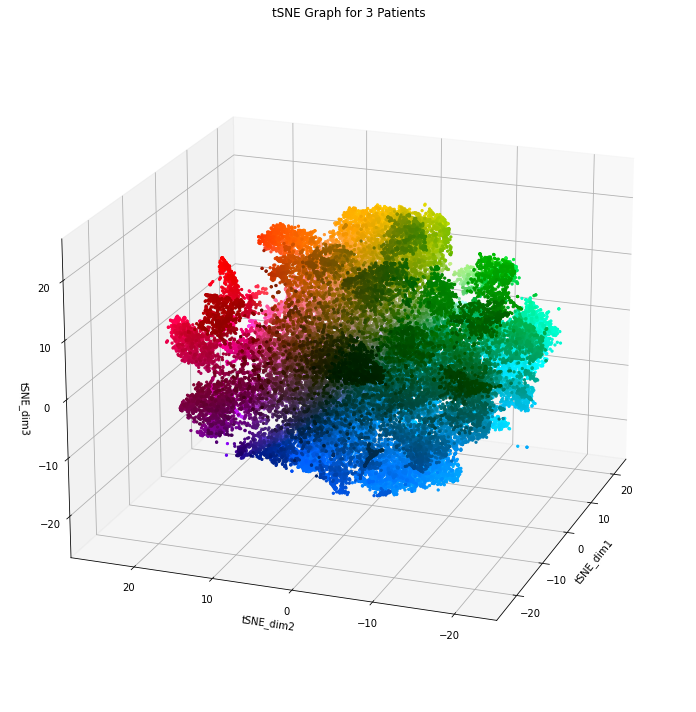

In [17]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = RGB_colors,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Graph for 3 Patients")

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


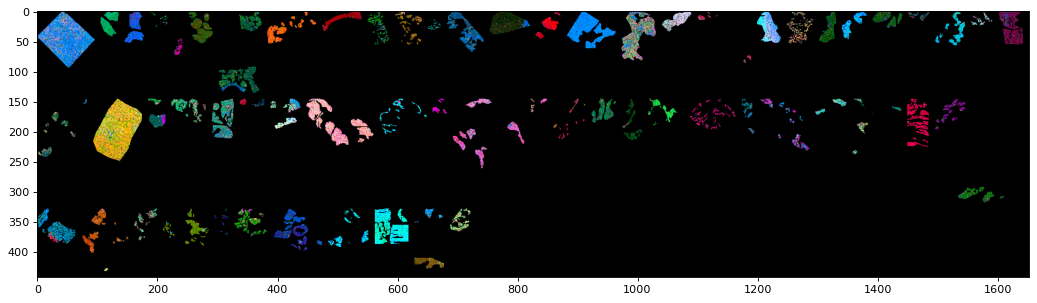

In [35]:
indices_edit = np.where(pixel_to_sample_ID != -1)
tsne_image = np.zeros( (height,width,3) )
increment = 0

for i,j in zip(indices_edit[0],indices_edit[1]):
    tsne_image[i][j][0] = RGB_colors[increment][0]
    tsne_image[i][j][1] = RGB_colors[increment][1]
    tsne_image[i][j][2] = RGB_colors[increment][2]
    increment += 1

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(tsne_image)


## Section 4 - Kmeans

In [19]:
stand_op_tsne = scaler.fit_transform(op_tsne_results) 

In [20]:
############# Sklearn K-mean #################
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=2000, random_state=42, verbose=0 ).fit(stand_op_tsne)

In [21]:
indices_edit = np.where(pixel_to_sample_ID != -1)
kmeans_image = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    kmeans_image[i][j] = kmeans.labels_[increment]
    increment += 1

In [22]:
########################## CV2 Kmeans ###############################
'''

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1500, 1)
 
k = 3
retval, labels, centers = cv2.kmeans(op_tsne_results, k, None, criteria, 10,cv2.KMEANS_PP_CENTERS)
print(labels.shape)

result_labels=labels


indices_edit = np.where(pixel_to_sample_ID != -1)
kmeans_image = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    kmeans_image[i][j] = result_labels[increment]
    increment += 1
    
'''


'\n\ncriteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1500, 1)\n \nk = 3\nretval, labels, centers = cv2.kmeans(op_tsne_results, k, None, criteria, 10,cv2.KMEANS_PP_CENTERS)\nprint(labels.shape)\n\nresult_labels=labels\n\n\nindices_edit = np.where(pixel_to_sample_ID != -1)\nkmeans_image = np.full( (height,width),-1 )\nincrement = 0\nfor i,j in zip(indices_edit[0],indices_edit[1]):\n    kmeans_image[i][j] = result_labels[increment]\n    increment += 1\n    \n'

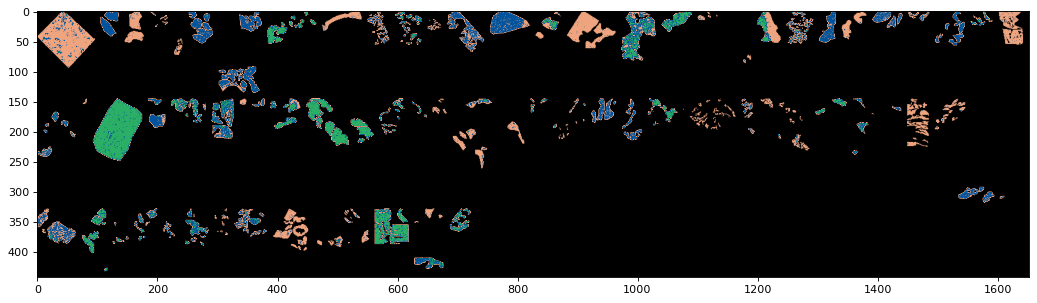

In [38]:
# Coloring the K-means image with specific chosen colors)

cvals = [0, 1, 2,3]
colors = ["black","#EEA47FFF","#00539CFF","#2BAE66FF"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list("", tuples)

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(kmeans_image, cmap=cmap)




In [24]:
# Zooming on sample id 13

specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
kmeans_labels_indicies = np.where(mask == True)

padding_factor = 2

zoomed_height_max = max(kmeans_labels_indicies[0]) + padding_factor
zoomed_height_min = min(kmeans_labels_indicies[0]) - padding_factor
zoomed_width_max = max(kmeans_labels_indicies[1]) + padding_factor
zoomed_width_min = min(kmeans_labels_indicies[1]) - padding_factor

if zoomed_height_max > height:
    zoomed_height_max= height

if zoomed_height_min < 0:
    zoomed_height_min= 0

if zoomed_width_max > width:
    zoomed_width_max= width

if zoomed_width_min < 0:
    zoomed_width_min= 0

kmeans_zoomedIn_image = kmeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

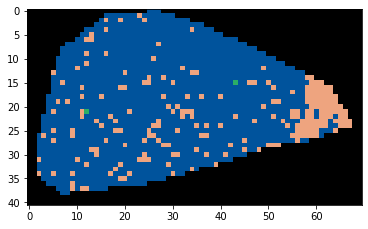

In [25]:
plt.imshow(kmeans_zoomedIn_image , cmap=cmap)

In [26]:
########### Bisecting K-mean  (not working, don't run it) ############

'''

K = 10
X = stand_op_tsne
current_clusters = 1
shape = 54835

chosen_cluster_all = np.empty(shape, dtype=float)

while current_clusters != K:
    kmeans = KMeans(n_clusters=2).fit(X)
    current_clusters += 1

    
    cluster_centers = kmeans.cluster_centers_
    sse = [0]*2
    for point, label in zip(X, kmeans.labels_):
        sse[label] += np.square(point-cluster_centers[label]).sum()
    chosen_cluster = np.argmax(sse, axis=0)
    print(chosen_cluster)
    chosen_cluster_data = X[kmeans.labels_ == chosen_cluster]
    X = chosen_cluster_data
    
'''






'\n\nK = 10\nX = stand_op_tsne\ncurrent_clusters = 1\nshape = 54835\n\nchosen_cluster_all = np.empty(shape, dtype=float)\n\nwhile current_clusters != K:\n    kmeans = KMeans(n_clusters=2).fit(X)\n    current_clusters += 1\n\n    \n    cluster_centers = kmeans.cluster_centers_\n    sse = [0]*2\n    for point, label in zip(X, kmeans.labels_):\n        sse[label] += np.square(point-cluster_centers[label]).sum()\n    chosen_cluster = np.argmax(sse, axis=0)\n    print(chosen_cluster)\n    chosen_cluster_data = X[kmeans.labels_ == chosen_cluster]\n    X = chosen_cluster_data\n    \n'

## Section 6 - Canny Edge

In [27]:
# Zooming on sample id 13

specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
kmeans_labels_indicies = np.where(mask == True)

padding_factor = 2

zoomed_height_max = max(kmeans_labels_indicies[0]) + padding_factor
zoomed_height_min = min(kmeans_labels_indicies[0]) - padding_factor
zoomed_width_max = max(kmeans_labels_indicies[1]) + padding_factor
zoomed_width_min = min(kmeans_labels_indicies[1]) - padding_factor


if zoomed_height_max > height:
    zoomed_height_max= height

if zoomed_height_min < 0:
    zoomed_height_min= 0

if zoomed_width_max > width:
    zoomed_width_max= width

if zoomed_width_min < 0:
    zoomed_width_min= 0
    
kmeans_zoomedIn_image = kmeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


###############


# Zooming on sample id 13

specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
tsne_indices = np.where(mask == True)


zoomed_height_max = max(tsne_indices[0]) + padding_factor
zoomed_height_min = min(tsne_indices[0]) - padding_factor
zoomed_width_max = max(tsne_indices[1]) + padding_factor
zoomed_width_min = min(tsne_indices[1]) - padding_factor

if zoomed_height_max > height:
    zoomed_height_max= height

if zoomed_height_min < 0:
    zoomed_height_min= 0

if zoomed_width_max > width:
    zoomed_width_max= width

if zoomed_width_min < 0:
    zoomed_width_min= 0



tsne_zoomedIn_image = tsne_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

In [ ]:
plt.figure(figsize=(16,8),dpi=100)
plt.imshow(tsne_zoomedIn_image)

In [ ]:
plt.figure(figsize=(16,8),dpi=100)
plt.imshow(kmeans_zoomedIn_image , cmap=cmap)

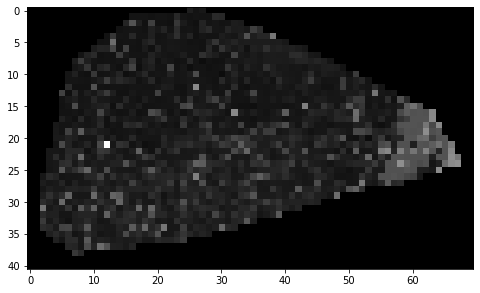

In [30]:
rgb_weights = [0.2989, 0.5870, 0.1140]
grayscale_image = np.dot(tsne_zoomedIn_image[...,:3], rgb_weights)
plt.figure(figsize = (8 , 6))
plt.imshow(grayscale_image,cmap='gray')

In [31]:
'''
def butterLow(cutoff, critical, order):
    normal_cutoff = float(cutoff) / critical
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butterFilter(data, cutoff_freq, nyq_freq, order):
    b, a = butterLow(cutoff_freq, nyq_freq, order)
    y = signal.filtfilt(b, a, data)
    return y
'''

"\ndef butterLow(cutoff, critical, order):\n    normal_cutoff = float(cutoff) / critical\n    b, a = signal.butter(order, normal_cutoff, btype='lowpass')\n    return b, a\n\ndef butterFilter(data, cutoff_freq, nyq_freq, order):\n    b, a = butterLow(cutoff_freq, nyq_freq, order)\n    y = signal.filtfilt(b, a, data)\n    return y\n"

In [32]:
'''

zoomed_heightshape , zoomed_widthshape = grayscale_image.shape
grayscale_image_flattened = grayscale_image.flatten()

cutoff_frequency = 1
sample_rate = np.max(grayscale_image_flattened) * 2 + 1

filtered_image = ( butterFilter(grayscale_image_flattened, cutoff_frequency, sample_rate/2 , 3) ).reshape( zoomed_heightshape , zoomed_widthshape)
plt.imshow(filtered_image)

'''

'\n\nzoomed_heightshape , zoomed_widthshape = grayscale_image.shape\ngrayscale_image_flattened = grayscale_image.flatten()\n\ncutoff_frequency = 1\nsample_rate = np.max(grayscale_image_flattened) * 2 + 1\n\nfiltered_image = ( butterFilter(grayscale_image_flattened, cutoff_frequency, sample_rate/2 , 3) ).reshape( zoomed_heightshape , zoomed_widthshape)\nplt.imshow(filtered_image)\n\n'

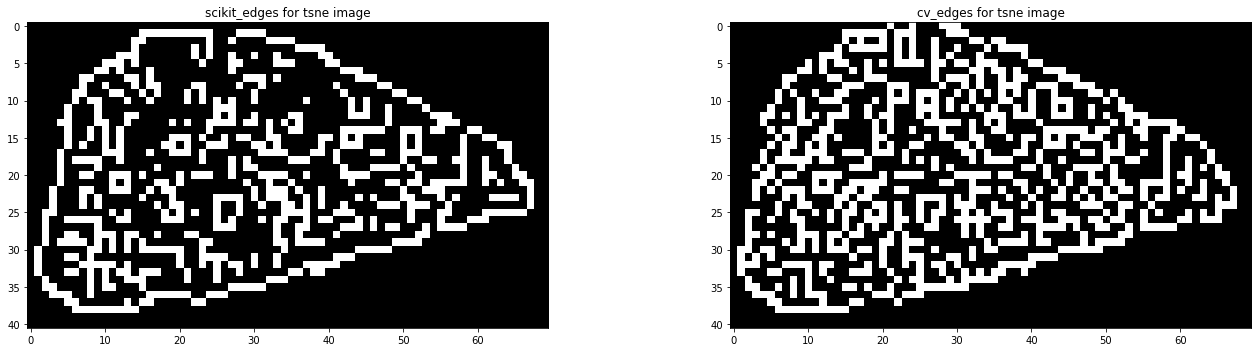

In [33]:
# tSNE edges results

mean = np.mean(grayscale_image.flatten() )

min_threshold = 0.33 * mean
max_threshold = 1.3 * mean

# min_threshold = int(max(0, (1- 0.5)* mean) )
# max_threshold = int(min(255, (1+ 0.5)* mean) )

edges_scikit = feature.canny(grayscale_image, sigma = 0.75, low_threshold = max_threshold , high_threshold = max_threshold)
edge_cv = cv2.Canny((grayscale_image*255).astype(np.uint8) , min_threshold , max_threshold,True)
#blur = cv2.GaussianBlur(grayscale_image,(3,3),0)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].set_title("scikit_edges for tsne image")
axes[1].set_title("cv_edges for tsne image")

axes[0].imshow(edges_scikit,cmap='gray')
axes[1].imshow(edge_cv,cmap='gray')
plt.tight_layout()

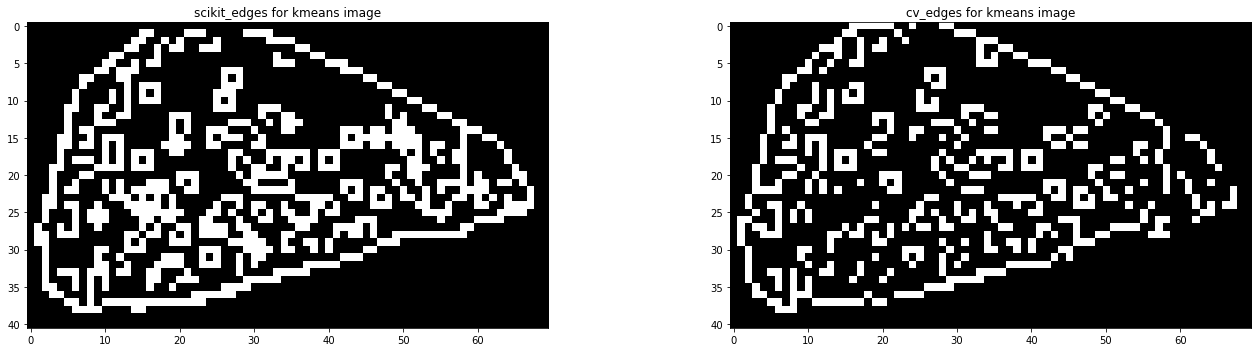

In [34]:
# Kmeans edges results

mean = np.mean(kmeans_zoomedIn_image.flatten() )

min_threshold = 0.33 * mean
max_threshold = 4 * min_threshold

# min_threshold = int(max(0, (1- 0.5)* mean) )
# max_threshold = int(min(255, (1+ 0.5)* mean) )

edges_scikit = feature.canny(kmeans_zoomedIn_image * 255, sigma = 0.06, low_threshold = min_threshold , high_threshold = max_threshold)
edge_cv = cv2.Canny( (kmeans_zoomedIn_image*255).astype(np.uint8) , min_threshold , max_threshold )

#blur = cv2.GaussianBlur(grayscale_image,(3,3),0)


fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].set_title("scikit_edges for kmeans image")
axes[1].set_title("cv_edges for kmeans image")

axes[0].imshow(edges_scikit,cmap='gray')
axes[1].imshow(edge_cv,cmap='gray')
plt.tight_layout()